In [23]:
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from gtfparse import read_gtf
import matplotlib.pyplot as plt
import csv
import io
import os


In [24]:
from collections import OrderedDict
import gzip


VCF_HEADER = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO']


def dataframe(filename, large=True):
    """Open an optionally gzipped VCF file and return a pandas.DataFrame with
    each INFO field included as a column in the dataframe.
    Note: Using large=False with large VCF files. It will be painfully slow.
    :param filename:    An optionally gzipped VCF file.
    :param large:       Use this with large VCF files to skip the ## lines and
                        leave the INFO fields unseparated as a single column.
    """
    if large:
        # Set the proper argument if the file is compressed.
        comp = 'gzip' if filename.endswith('.gz') else None
        # Count how many comment lines should be skipped.
        comments = _count_comments(filename)
        # Return a simple DataFrame without splitting the INFO column.
        return pd.read_table(filename, compression=comp, skiprows=comments,
                             names=VCF_HEADER, usecols=range(8))

    # Each column is a list stored as a value in this dict. The keys for this
    # dict are the VCF column names and the keys in the INFO column.
    result = OrderedDict()
    # Parse each line in the VCF file into a dict.
    for i, line in enumerate(lines(filename)):
        for key in line.keys():
            # This key has not been seen yet, so set it to None for all
            # previous lines.
            if key not in result:
                result[key] = [None] * i
        # Ensure this row has some value for each column.
        for key in result.keys():
            result[key].append(line.get(key, None))

    return pd.DataFrame(result)


def lines(filename):
    """Open an optionally gzipped VCF file and generate an OrderedDict for
    each line.
    """
    fn_open = gzip.open if filename.endswith('.gz') else open

    with fn_open(filename) as fh:
        for line in fh:
            if line.startswith('#'):
                continue
            else:
                yield parse(line)


def parse(line):
    """Parse a single VCF line and return an OrderedDict.
    """
    result = OrderedDict()

    fields = line.rstrip().split('\t')

    # Read the values in the first seven columns.
    for i, col in enumerate(VCF_HEADER[:7]):
        result[col] = _get_value(fields[i])

    # INFO field consists of "key1=value;key2=value;...".
    infos = fields[7].split(';')

    for i, info in enumerate(infos, 1):
        # info should be "key=value".
        try:
            key, value = info.split('=')
        # But sometimes it is just "value", so we'll make our own key.
        except ValueError:
            key = 'INFO{}'.format(i)
            value = info
        # Set the value to None if there is no value.
        result[key] = _get_value(value)

    return result


def _get_value(value):
    """Interpret null values and return ``None``. Return a list if the value
    contains a comma.
    """
    if not value or value in ['', '.', 'NA']:
        return None
    if ',' in value:
        return value.split(',')
    return value


def _count_comments(filename):
    """Count comment lines (those that start with "#") in an optionally
    gzipped file.
    :param filename:  An optionally gzipped file.
    """
    comments = 0
    fn_open = gzip.open if filename.endswith('.gz') else open
    with fn_open(filename) as fh:
        for line in fh:
            if line.startswith('#'):
                comments += 1
            else:
                break
    return comments

In [25]:

# reading the fasta file (one record)
OriginalSeq=[]
seq_file = SeqIO.read("data/chr22.fa", "fasta")
OriginalSeq=seq_file.seq


In [26]:
MutationsDf = dataframe("data/chr22mutations.vcf")

In [27]:
# De-crement indices by 1 for zero-index code
MutationsDf.loc[:, "POS"] -= 1

In [28]:
NewSequence = list(str(OriginalSeq))
for i in range(len(MutationsDf)):
    Position = MutationsDf['POS'].iloc[i]
    NewSequence[Position] = MutationsDf['ALT'].iloc[i]
NewSequence = "".join(NewSequence)


In [29]:
AnnotationsDf = read_gtf("data/chr22geneannotations.gtf")

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name', 'exon_number', 'exon_id', 'level', 'protein_id', 'transcript_support_level', 'hgnc_id', 'tag', 'ccdsid', 'havana_gene', 'havana_transcript']


In [30]:
sorted_AnnotationsDf = AnnotationsDf.sort_values(by=["gene_name", "start" , "end"])  # Sort by gene name, and then by start and end position ascendingly
start_end_strand=sorted_AnnotationsDf[["start","end","strand","gene_name","transcript_name"]]

# De-crement indices by 1 for zero-index code
start_end_strand.loc[:, "start"] -= 1
start_end_strand.loc[:, "end"] -= 1

C:\Users\omars\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [31]:
Codontable = {
    "TTT":"Phe", "TTC":"Phe", "TTA": "Leu", "TTG":"Leu",
    "CTT":"Leu", "CTC":"Leu", "CTA": "Leu", "CTG":"Leu",
    "ATT":"Ile", "ATC":"Ile", "ATA": "Ile", "ATG":"Met",
    "GTT":"Val", "GTC":"Val", "GTA": "Val", "GTG":"Val",


    "TCT":"Ser", "TCC":"Ser", "TCA": "Ser", "TCG":"Ser",
    "CCT":"Pro", "CCC":"Pro", "CCA": "Pro", "CCG":"Pro",
    "ACT":"Thr", "ACC":"Thr", "ACA": "Thr", "ACG":"Thr",
    "GCT":"Ala", "GCC":"Ala", "GCA": "Ala", "GCG":"Ala",


    "TAT":"Tyr", "TAC":"Tyr", "TAA": "","TAG":"",
    "CAT":"His", "CAC":"His", "CAA": "Gln", "CAG":"Gln",
    "AAT":"Asn", "AAC":"Asn", "AAA": "Lys", "AAG":"Lys",
    "GAT":"Asp", "GAC":"Asp", "GAA": "Glu", "GAG":"Glu",


    "TGT":"Cys", "TGC":"Cys", "TGA": "","TGG":"Trp",
    "CGT":"Arg", "CGC":"Arg", "CGA": "Arg", "CGG":"Arg",
    "AGT":"Ser", "AGC":"Ser", "AGA": "Arg", "AGG":"Arg",
    "GGT":"Gly", "GGC":"Gly", "GGA": "Gly", "GGG":"Gly",
    "GGN":"Gly", "NNN": "XXX"


}

CodonOneCodetable = {

    "Ala": "A" , "Arg": "R" , "Gly": "G" ,
    "Asp": "D" , "Asx": "B" , "Cys": "C" ,
    "Gln": "Q" , "Glu": "E" , "Asn": "N" ,
    "Glx": "Z" , "Gly": "G" , "His": "H" ,
    "Ile": "I" , "Leu": "L" , "Lys": "K" ,
    "Met": "M" , "Phe": "F" , "Pro": "P" ,
    "Ser": "S" , "Thr": "T" , "Trp": "W" ,
    "Tyr": "Y" , "Val": "V" , "XXX": "X" ,
    "" : "" 


}
MassTable = {
    "A": 89 , "R": 174 , "G": 132 ,
    "D": 133, "B": 133 , "C": 121 ,
    "Q": 146 ,"E": 147 ,"N": 132  ,
    "Z": 147, "G": 147 , "H": 155 ,
    "I": 131, "L": 131 , "K": 146 ,
    "M": 149, "F": 165 , "P": 115 ,
    "S": 105, "T": 119 , "W": 204 ,
    "Y": 181, "V": 117 , "X": 0 
    
}

def TranslateManual(Sequence):

    protein = ""
    for i in range(0, len(Sequence) , 3):
            codon = Sequence[i:i + 3]
            if codon[2] == "N" or codon[1] == "N" or codon[0] == "N":
                protein += "X"
            else:
                protein += CodonOneCodetable[Codontable[codon.upper()]]
    return protein

def CalculateMassManual(Sequence):
    Sum = 0
    for i in range(0, len(Sequence)):
            protein = Sequence[i]
            Sum += MassTable[protein]
    return Sum


In [32]:
def Output_Dictionary_Mass(seq,start_end_strand):
    Protein=[]
    Gene_Region=[]
    Dictionary = { "Gene Seq": [] , "Gene Name": [] , "Protein Seq" : [] , "Mass": [] }

    for i in range(len(start_end_strand)):

        if start_end_strand['strand'].iloc[i]=="+":
            Gene_Region.append( str(seq[start_end_strand['start'].iloc[i]:start_end_strand['end'].iloc[i]]) )

        elif start_end_strand['strand'].iloc[i]=="-":
            Gene_Region.append( str( seq[start_end_strand['start'].iloc[i]:start_end_strand['end'].iloc[i]].reverse_complement() ) )

        # Break condition
        if i == len(start_end_strand)-1:
            Merged_Gene_Region = ''.join(Gene_Region)  # Append all sequences of coding into 1 sequence

            # Check for adding trailing N-sequence to make translation correct, is needed to make sequence divisible by 3
            #--------------------------------
            remainder = len(Merged_Gene_Region) % 3
            if remainder != 0:
                Merged_Gene_Region = Merged_Gene_Region + 'N' * (3 - remainder)
            #------------------------------------------------------------
            Merged_Gene_Region = Seq(Merged_Gene_Region)
            #Protein=Merged_Gene_Region.translate(to_stop=True,cds=True)
            Protein = TranslateManual(str(Merged_Gene_Region))


            Dictionary["Gene Name"].append(start_end_strand['gene_name'].iloc[i])
            Dictionary["Protein Seq"].append(Protein)
            Dictionary["Gene Seq"].append(Merged_Gene_Region)

            #analysed_seq = ProteinAnalysis(str(Protein))
            #Dictionary['Mass'].append(analysed_seq.molecular_weight())
            massValue = CalculateMassManual(Protein)
            Dictionary['Mass'].append(massValue)

            Gene_Region = [ ] # Reset Gene_Region for new protein
            Merged_Gene_Region = [ ]
            break

        # Translating Entire Gene Condition
        if start_end_strand['gene_name'].iloc[i] != start_end_strand['gene_name'].iloc[i+1]:
            Merged_Gene_Region = ''.join(Gene_Region)  # Append all sequences of coding into 1 sequence
            
            # Check for adding trailing N-sequence to make translation correct, is needed to make sequence divisible by 3
            #--------------------------------
            remainder = len(Merged_Gene_Region) % 3
            if remainder != 0:
                Merged_Gene_Region = Merged_Gene_Region + 'N' * (3 - remainder)
            #------------------------------------------------------------
            Merged_Gene_Region = Seq(Merged_Gene_Region)

            Protein = TranslateManual(str(Merged_Gene_Region))
            Dictionary["Gene Name"].append(start_end_strand['gene_name'].iloc[i])
            Dictionary["Protein Seq"].append(Protein)
            Dictionary["Gene Seq"].append(Merged_Gene_Region)

            massValue = CalculateMassManual(Protein)
            Dictionary['Mass'].append(massValue)
            
            Gene_Region = [ ] # Reset Gene_Region for new protein
            Merged_Gene_Region = [ ]

    return Dictionary


       

In [33]:
RefData=pd.DataFrame.from_dict( Output_Dictionary_Mass(OriginalSeq,start_end_strand) )
sorted_RefData= RefData.sort_values(by=["Mass"] , ascending=False)

MutatedData = pd.DataFrame.from_dict( Output_Dictionary_Mass(Seq(NewSequence),start_end_strand) )
sorted_MutatedData = MutatedData.sort_values(by=["Mass"] , ascending=False)

sorted_MutatedData["MassDifference"] = sorted_MutatedData["Mass"] - sorted_RefData["Mass"]  # Adding a new column for Mass Difference

In [34]:
sorted_RefData

,Gene Seq,Gene Name,Protein Seq,Mass
64,"(G, G, C, A, G, T, A, A, T, G, A, A, A, C, T, ...",CELSR1,GSNETSIHLEKSHLPAAADADGADAEGPAPGEAGRLAEPHILAHVF...,394401
207,"(A, T, G, G, C, C, A, T, C, T, C, A, T, C, A, ...",MYO18B,MAISSRLALWEQKFGKRTRALHHPRPLLFSLSSQGASLSNWSGGLK...,334956
373,"(T, T, C, T, A, C, T, G, A, G, C, T, A, C, C, ...",TTC28,FYATQAPQPQLLLPRVSCFCSVCFQRPALGLPATPLLSHRCGQHRL...,319153
111,"(A, T, G, G, C, C, G, A, G, A, A, T, G, T, G, ...",EP300,MAENVVEPGPPSAKRPKLSSPALSASASDGTILALYLTWSTTYQMN...,311798
367,"(A, T, G, G, A, G, G, A, G, G, T, G, C, C, T, ...",TRIOBP,MEEVPGDALCEHFEANILTQNRCQNCFHPEEAHGARYQSSGALQVL...,304768
...,...,...,...,...
322,"(A, T, G, G, C, G, T, C, C, G, G, A, G, C, G, ...",SMDT1,MASGAARWLVLAPVRSGALRSGPSLRKDGDVSAAWSGSGRSLVPSR...,13694
100,"(G, C, G, C, C, G, C, C, A, A, G, A, T, G, A, ...",DNAL4,APPRSKRQWTRSSAPPGTWSARALGLRSPTRRTSSTCTSGAPWLCA...,13346
31,"(T, G, G, C, T, C, C, A, T, T, T, G, T, C, C, ...",ATP5MGL,WLHLSVTLWRRPQHWMLLLTSLDWPHFGTTPRLSWFLPPLLRSLEL...,12828
336,"(G, C, A, G, G, C, G, A, C, C, T, G, G, A, T, ...",SYCE3,AGDLDGLHGGDAHQPYAGRVHASAGGCLRQLQGGDGEELARAAADQ...,11329


In [35]:
GeneName_Mass_Original= sorted_RefData[["Gene Name", "Mass"]]
GeneName_Mass_Original=GeneName_Mass_Original.rename(columns={'Mass': 'Original Mass'})

In [36]:
GeneName_Mass_Original

,Gene Name,Original Mass
64,CELSR1,394401
207,MYO18B,334956
373,TTC28,319153
111,EP300,311798
367,TRIOBP,304768
...,...,...
322,SMDT1,13694
100,DNAL4,13346
31,ATP5MGL,12828
336,SYCE3,11329


In [37]:
Merged_masses = sorted_MutatedData.merge(GeneName_Mass_Original,how='inner',left_on=['Gene Name'],right_on=["Gene Name"])

In [38]:
Merged_masses

,Gene Seq,Gene Name,Protein Seq,Mass,MassDifference,Original Mass
0,"(G, G, C, A, G, T, A, A, T, G, A, A, A, C, T, ...",CELSR1,GSNETSIHLEKSHLPAAADADGADAEGPAPGEAGRLAEPHILAHVF...,394419,18,394401
1,"(A, T, G, G, C, C, A, T, C, T, C, A, T, C, A, ...",MYO18B,MAISSRLALWEQKFGKRTRALHHPRPLLFSLSSQGASLSNWSGGLK...,334907,-49,334956
2,"(T, T, C, T, A, C, T, G, A, G, C, T, A, C, C, ...",TTC28,FYATQAPQPQLLLPRVSCFCSVCFQRPALGLPATPLLSHRCGQHRL...,319165,12,319153
3,"(A, T, G, G, C, C, G, A, G, A, A, T, G, T, G, ...",EP300,MAENVVEPGPPSAKRPKLSSPALSASASDGTILALYLTWSTTYQMN...,311692,-106,311798
4,"(A, T, G, G, A, G, G, A, G, G, T, G, C, C, T, ...",TRIOBP,MEEVPGDALCEHFEANILTQNRCQNCFHPEEAHGARYQSSGALQVL...,304783,15,304768
...,...,...,...,...,...,...
403,"(A, T, G, G, C, G, T, C, C, G, G, A, G, C, G, ...",SMDT1,MASGAARWLVLAPVRSGALRSGPSLRKDGDVSAAWSGSGRSLVPSR...,13694,0,13694
404,"(G, C, G, C, C, G, C, C, A, A, G, A, T, G, A, ...",DNAL4,APPRSKRQWTRSSAPPGTWSARALGLRSPTRRTSSTCTSGAPWLCA...,13346,0,13346
405,"(T, G, G, C, T, C, C, A, T, T, T, G, T, C, C, ...",ATP5MGL,WLHLSVTLWRRPQHWMLLLTSLDWPHFGTTPRLSWFLPPLLRSLEL...,12828,0,12828
406,"(G, C, A, G, G, C, G, A, C, C, T, G, G, A, T, ...",SYCE3,AGDLDGLHGGDAHQPYAGRVHASAGGCLRQLQGGDGEELARAAADQ...,11329,0,11329


In [39]:
# Printing two different CSVs to show REF and ALT data as tables , showing the masses sorted by highest for chromosome
sorted_RefData.to_csv("Output_REF_Masses_Sorted.csv" , index = False)
sorted_MutatedData.to_csv("Output_ALT_Masses.csv" , index = False)

In [40]:
massDifferencesList = list(Merged_masses["MassDifference"]) # (Difference in massess) Mutation - Original
Gene_names=list(Merged_masses["Gene Name"])
Original_mass=list(Merged_masses["Original Mass"])  #Original Mass
Mutated_mass=list(Merged_masses["Mass"]) # Mutated Mass

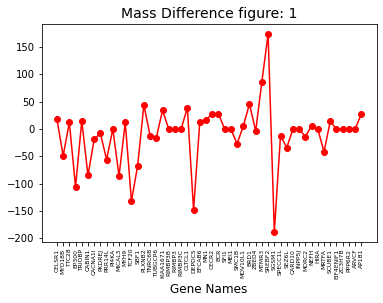

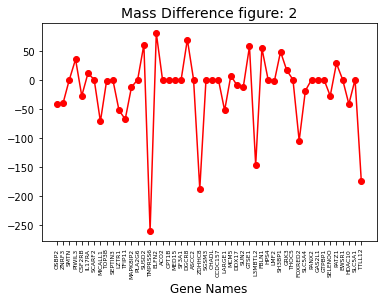

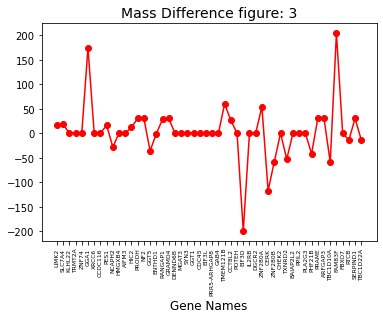

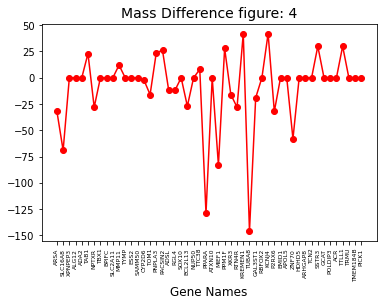

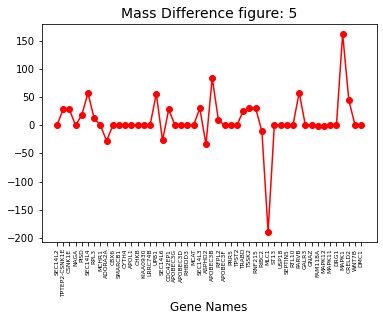

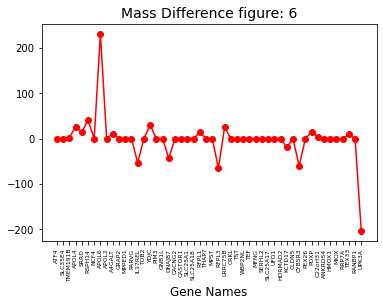

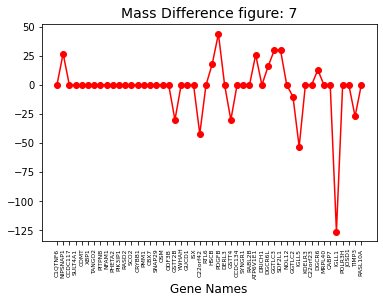

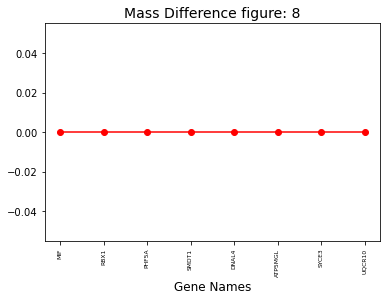

In [41]:

# Line Graph visualization for relatonship between absolute change of mass with the original mass
divisor = 50
iterations = int(len( Merged_masses ) / divisor)
for i in range(0,iterations):

    if i == iterations-1:
        
        plot = plt.figure(i)
        plt.plot(Gene_names[(i+1)*divisor::],massDifferencesList[(i+1)*divisor::],marker='o',color='red')
        plt.title('Mass Difference figure: ' + str(i+1), fontsize=14)
        plt.xlabel('Gene Names', fontsize=12)
        plt.xticks(range(len(Gene_names[(i+1)*divisor::])), Gene_names[(i+1)*divisor::], size='small',fontsize=6,rotation="vertical")
        break
    
    plot = plt.figure(i)
    plt.plot(Gene_names[i*divisor:(i+1)*divisor],massDifferencesList[i*divisor:(i+1)*divisor],marker='o',color='red')
    plt.title('Mass Difference figure: ' + str(i+1), fontsize=14)
    plt.xlabel('Gene Names', fontsize=12)
    plt.xticks(range(len(Gene_names[i*divisor:(i+1)*divisor])), Gene_names[i*divisor:(i+1)*divisor], size='small',fontsize=6,rotation="vertical")

20
C:\Users\omars\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


<Figure size 432x288 with 0 Axes>

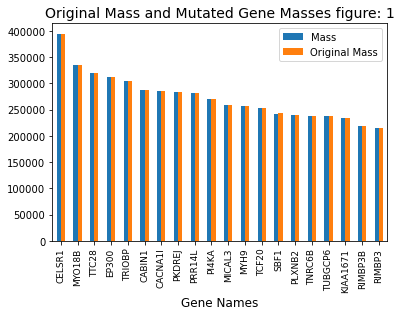

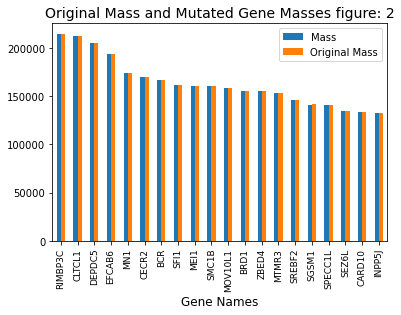

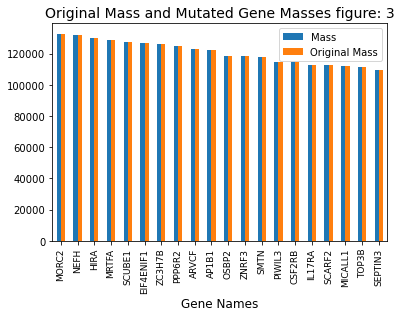

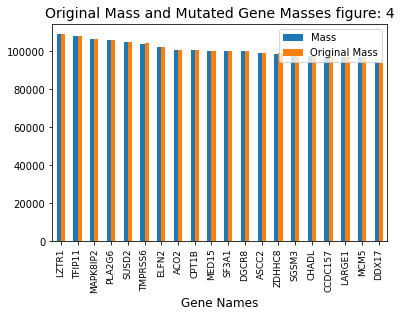

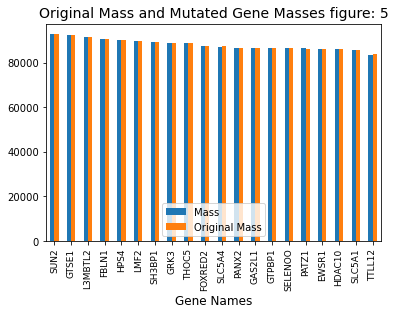

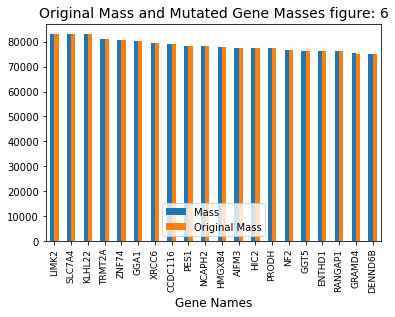

Error in callback <function flush_figures at 0x000001947CE52940> (for post_execute):


KeyboardInterrupt: 

In [43]:

# Bar Graph ( Original Mass and Mutated Genes Mass )
divisor=20
iterations = int(len( Merged_masses ) / divisor)
for i in range(0,iterations):

    if i == iterations-1:
        

        Merged_masses_part=Merged_masses.iloc[(i+1)*divisor::,:]
        Merged_masses_part.plot(x="Gene Name", y=["Mass", "Original Mass"], kind="bar")
        plt.title('Original Mass and Mutated Gene Masses figure: ' + str(i+1), fontsize=14)
        plt.xticks(range(len(Gene_names[(i+1)*divisor::])), Gene_names[(i+1)*divisor::], size='small',fontsize=9,rotation="vertical")
        plt.xlabel('Gene Names', fontsize=12)
        break
        
    plot = plt.figure(i)
    Merged_masses_part=Merged_masses.iloc[i*divisor:(i+1)*divisor,:]
    Merged_masses_part.plot(x="Gene Name", y=["Mass", "Original Mass"], kind="bar")
    plt.title('Original Mass and Mutated Gene Masses figure: ' + str(i+1), fontsize=14)
    plt.xticks(range(len(Gene_names[i*divisor:(i+1)*divisor])), Gene_names[i*divisor:(i+1)*divisor], size='small',fontsize=9,rotation="vertical")
    plt.xlabel('Gene Names', fontsize=12)
